# BIZ 프로젝트 : 부실기업 예측 모형에 관한 연구

## Step3 : Modeling - 3개년도 ML 구축

- y: 23년도 부실기업 여부
- x: 20,21,22년도 데이터

In [10]:
from google.colab import files
uploaded=files.upload()

Saving data_20to22.csv to data_20to22.csv


In [ ]:
pip install numpy pandas scikit-learn xgboost catboost lightgbm optuna matplotlib seaborn

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  # StandardScaler 임포트 추가
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
import optuna

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [8]:
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False

In [11]:
RANDOM_STATE = 110

data_20to22 = pd.read_csv("data_20to22.csv", encoding='utf-8-sig', low_memory=False)
print(data_20to22.shape)

(27603, 101)


In [12]:
# 종속 변수는 '2023/부실기업'으로 가정
y = data_20to22['2023/부실기업']
X = data_20to22.drop(columns=['2023/부실기업', '업체코드', '종목명'])

# 데이터 분할 (70:30 비율)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 데이터 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# 모델 정의
models = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=200, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'CatBoost': CatBoostClassifier(silent=True, random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

In [14]:
# 하이퍼파라미터 튜닝 함수
def objective(trial, model_name):
    if model_name == 'Random Forest':
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        max_depth = trial.suggest_int('max_depth', 1, 32)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    elif model_name == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        model = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
    elif model_name == 'CatBoost':
        depth = trial.suggest_int('depth', 1, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        model = CatBoostClassifier(depth=depth, learning_rate=learning_rate, silent=True, random_state=42)
    elif model_name == 'LightGBM':
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        model = LGBMClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
    else:
        return 0  # 거리 기반 모델은 튜닝하지 않음

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return f1_score(y_test, y_pred, average='weighted')

In [15]:
# 하이퍼파라미터 튜닝 함수
def objective(trial, model_name):
    if model_name == 'Random Forest':
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        max_depth = trial.suggest_int('max_depth', 1, 32)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    elif model_name == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        model = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
    elif model_name == 'CatBoost':
        depth = trial.suggest_int('depth', 1, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        model = CatBoostClassifier(depth=depth, learning_rate=learning_rate, silent=True, random_state=42)
    elif model_name == 'LightGBM':
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        model = LGBMClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
    else:
        return 0  # 거리 기반 모델은 튜닝하지 않음

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return f1_score(y_test, y_pred, average='weighted')

In [16]:
# 모델 성능 평가 및 시각화
results = {}
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # SVM과 KNN의 경우 확률 예측을 추가
    if model_name in ['SVM', 'KNN']:
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_proba = model.predict_proba(X_test_scaled)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label=1)
    roc_auc = auc(fpr, tpr)

    results[model_name] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'model': model
    }

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:48:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 3589, number of negative: 15733
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24693
[LightGBM] [Info] Number of data points in the train set: 19322, number of used features: 98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.185747 -> initscore=-1.477887
[LightGBM] [Info] Start training from score -1.477887


Random Forest:
  Accuracy: 0.9502
  F1 Score: 0.9513
  ROC AUC: 0.9846

SVM:
  Accuracy: 0.9151
  F1 Score: 0.9126
  ROC AUC: 0.9606

KNN:
  Accuracy: 0.8855
  F1 Score: 0.8794
  ROC AUC: 0.8791

Logistic Regression:
  Accuracy: 0.9029
  F1 Score: 0.8993
  ROC AUC: 0.9534

XGBoost:
  Accuracy: 0.9481
  F1 Score: 0.9491
  ROC AUC: 0.9838

CatBoost:
  Accuracy: 0.9511
  F1 Score: 0.9524
  ROC AUC: 0.9854

LightGBM:
  Accuracy: 0.9527
  F1 Score: 0.9539
  ROC AUC: 0.9849



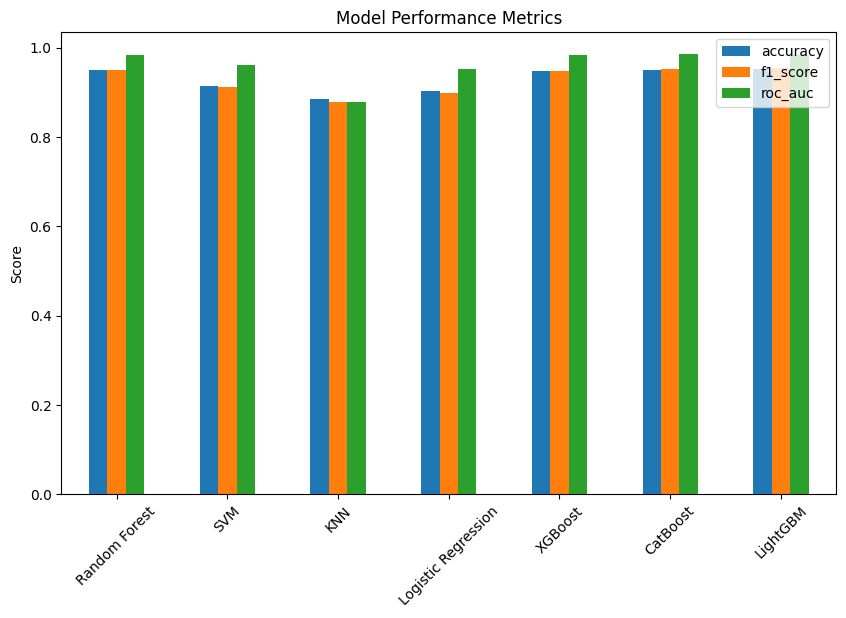

In [17]:
# 성능 지표 시각화 및 출력
import pandas as pd
metrics_df = pd.DataFrame(results).T

# 각 모델의 성능 지표 출력
for model_name, metrics in metrics_df.iterrows():
    print(f"{model_name}:")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  F1 Score: {metrics['f1_score']:.4f}")
    print(f"  ROC AUC: {metrics['roc_auc']:.4f}\n")

# 성능 지표 시각화
metrics_df[['accuracy', 'f1_score', 'roc_auc']].plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

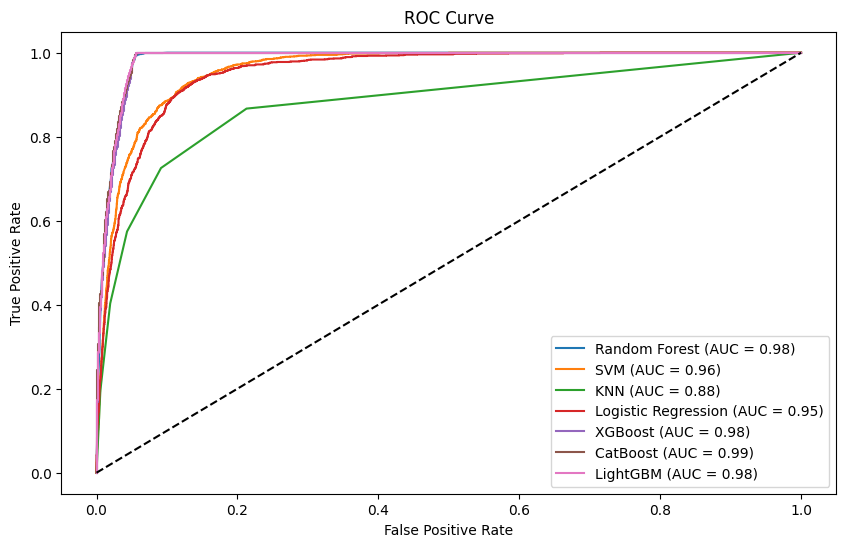

In [19]:
# ROC Curve 시각화
plt.figure(figsize=(10, 6))
for model_name, result in results.items():
    plt.plot(result['fpr'], result['tpr'], label=f'{model_name} (AUC = {result["roc_auc"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [18]:
#하이퍼 파라미터 튜닝 (Optuna 사용)

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import optuna
from sklearn.preprocessing import LabelEncoder

# Load your dataset
data = pd.read_csv('data_20to22.csv')

# Prepare the dataset
# Drop rows with missing target values and non-numeric columns
data = data.dropna(subset=['2023/부실기업'])
data = data.select_dtypes(include=[np.number]).dropna()

# Define features (X) and target (y)
X = data.drop(columns=['2023/부실기업'])
y = data['2023/부실기업']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to optimize using Optuna
def objective(trial):
    # Hyperparameters to be tuned
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])

    # Create the model with suggested hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )

    # Fit and validate the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Optuna aims to maximize the objective
    return accuracy

# Start the optimization with Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Best hyperparameters
best_params = study.best_params
best_score = study.best_value

print(f"Best Hyperparameters: {best_params}")
print(f"Best Accuracy Score: {best_score}")



[I 2024-11-18 07:49:28,534] A new study created in memory with name: no-name-84bacacd-e373-400a-b730-49c3bcb2ebda
[I 2024-11-18 07:49:35,795] Trial 0 finished with value: 0.9452997645354102 and parameters: {'n_estimators': 103, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 0 with value: 0.9452997645354102.
[I 2024-11-18 07:49:41,340] Trial 1 finished with value: 0.9333454084405 and parameters: {'n_estimators': 97, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9452997645354102.
[I 2024-11-18 07:49:45,439] Trial 2 finished with value: 0.9337076616554972 and parameters: {'n_estimators': 101, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9452997645354102.
[I 2024-11-18 07:49:51,616] Trial 3 finished with value: 0.9376924470204673 and parameters: {'n_estimators': 129, 'max_depth': 5, 'min_

Best Hyperparameters: {'n_estimators': 95, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 15, 'max_features': None}
Best Accuracy Score: 0.9539938416953451
